In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime, timedelta

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [6]:
sys.path.append("../code/")

In [7]:
import src

### parameters for papermill 

In [8]:
domain = "NZ"
ipath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 30
ndays_back = 365 * 10
quantile = .9
lag = 5

### get the pathlib paths for the data and the climatology 

In [9]:
ipath = pathlib.Path(ipath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [10]:
current_date = datetime.utcnow()

### get the first day of the period to extract 

In [11]:
first_day = current_date - timedelta(days=ndays_back)

## get the years to read 

In [12]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [13]:
lfiles = [ipath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [14]:
lfiles.sort()

In [15]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2012.v2.nc')

In [16]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [17]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords", engine='netcdf4') 

In [18]:
dset

<xarray.Dataset>
Dimensions:  (time: 3992, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2022-12-05
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 80, 72), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [19]:
if ndays_agg > 1:

    dset = dset.rolling({"time": ndays_agg}, min_periods=ndays_agg, center=False).mean(
        "time"
    )

    dset = dset.isel(time=slice(ndays_agg + 1, None))

### first and last day in the dataset 

In [20]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

### get rid of the 29th of Feb if present 

In [21]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [22]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [23]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (lat, lon, dayofyear) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [24]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

/home/nicolasf/mambaforge/envs/OISST/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


### repeat the climatology over the time dimension 

In [25]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

/home/nicolasf/mambaforge/envs/OISST/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


In [26]:
clim_repeat

,Array,Chunk
Bytes,173.94 MiB,514.69 kiB
Shape,"(80, 72, 3958)","(20, 18, 183)"
Count,3 Graph Layers,352 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,869.68 MiB,1.01 MiB
Shape,"(3958, 5, 80, 72)","(92, 2, 20, 36)"
Count,3 Graph Layers,1056 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### derive the mask highlighting MHW conditions

In [27]:
mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))
mask = mask.where(np.isnan(mask), other=1)

### Now select the maps to plot 

In [28]:
dataarray_anoms = anoms.isel(time=(-lag - 1))["sst"]

In [29]:
dataarray_raw = dset.isel(time=(-lag - 1))["sst"]

In [30]:
dataarray_mask = mask.isel(time=(-lag - 1))

### Interpolate over the missing (land) grid points, for smooth plotting 

In [34]:
dataarray_anoms = src.interpolate_NaN_da(dataarray_anoms)

In [35]:
dataarray_raw = src.interpolate_NaN_da(dataarray_raw)

In [36]:
cmap = cmocean.cm.balance

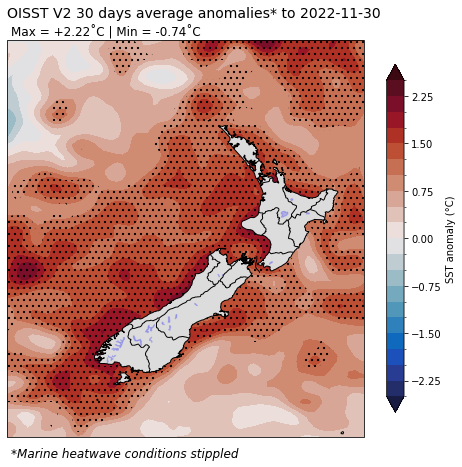

In [37]:
f, ax = src.plot_SST_map(
    dataarray_anoms,
    dataarray_mask,
    ndays_agg=ndays_agg,
    levels=np.arange(-2.5, 2.5 + 0.25, 0.25),
)

In [39]:
fig_path

PosixPath('/home/nicolasf/operational/OISST_indices/figures')

In [40]:
f.savefig(
    fig_path.joinpath(f"proto_OISST_anoms_{ndays_agg:02d}_days.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

### Now calculates the number of heatwaves periods (consecutive periods to date > 90th percentile) 

In [41]:
heatwaves_days = mask.copy()

In [42]:
heatwaves_days = heatwaves_days.fillna(0)

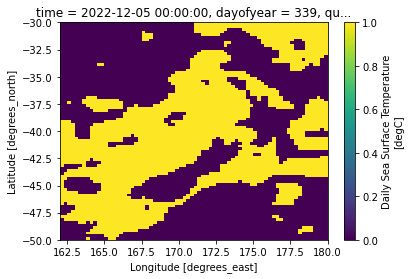

In [43]:
heatwaves_days[-1, :, :].plot()

In [44]:
heatwaves_days = 1 - heatwaves_days

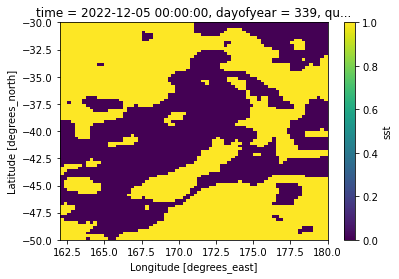

In [45]:
heatwaves_days[-1, :, :].plot()

In [46]:
heatwaves_days_consecutive = heatwaves_days.cumsum(dim="time", keep_attrs=True)

In [47]:
heatwaves_days_consecutive["time"] = (
    ("time"),
    np.arange(len(heatwaves_days.time))[::-1],
)

In [48]:
heatwaves_days_consecutive = heatwaves_days_consecutive.idxmax(dim="time")

In [49]:
heatwaves_days_consecutive

<xarray.DataArray 'time' (lat: 80, lon: 72)>
dask.array<where, shape=(80, 72), dtype=float64, chunksize=(10, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon       (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
    quantile  float64 0.9

In [50]:
import palettable

In [51]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

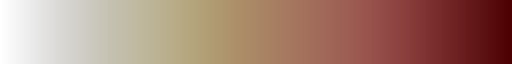

In [52]:
cmap

In [53]:
import cartopy.feature as cfeature

states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="10m",
    facecolor="none",
)

lakes = cfeature.NaturalEarthFeature("physical", "lakes", "10m")
land = cfeature.NaturalEarthFeature("physical", "land", "10m")

In [54]:
from cartopy import crs as ccrs

In [55]:
cbar_kwargs = {"shrink": 0.8, "label": "nb. of periods"}

Text(0.5, 1.0, 'OISST V2 30 day(s) to 2022-12-05\nNumber of consecutive 30 day(s) periods\nabove 90th percentile')

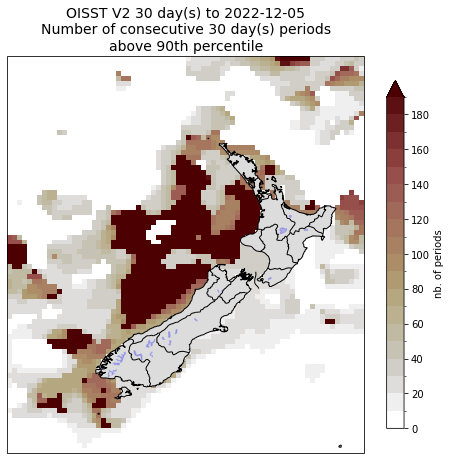

In [56]:
f, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),
)

heatwaves_days_consecutive.plot(
    ax=ax,
    levels=np.arange(0, 200, 10),
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    cbar_kwargs=cbar_kwargs,
)

ax.add_feature(land, facecolor="gainsboro")
ax.add_feature(lakes, facecolor="b", edgecolor="b", alpha=0.2)
ax.add_feature(states_provinces, edgecolor="k", linewidth=1)
ax.coastlines("10m", linewidth=1)

ax.set_title(
    f"OISST V2 {ndays_agg} day(s) to {last_day:%Y-%m-%d}\nNumber of consecutive {ndays_agg} day(s) periods\nabove {int(quantile*100):02d}th percentile",
    fontsize=14,
)

In [57]:
f.savefig(
    fig_path.joinpath(f"proto_OISST_heatwave_days_{ndays_agg:02d}_days.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)